In [471]:
import pandas as pd
import math
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
import plotly.express as px
from numpy import diff
from scipy.signal import butter, lfilter



In [472]:
d= pd.read_csv('lab4data/pathimu.csv')
ds=pd.read_csv('lab4data/pathgps.csv')
mag_x=d['field.MagField.magnetic_field.x']
mag_y=d['field.MagField.magnetic_field.y']
timeimu=np.array((d['field.Header.stamp']-1.69826434830611e+18)/1000000000)

# timeimu=timeimu[1949:21748]
# timeimu=(timeimu-1.69826424943413e+18)/1000000000
timeimu[21740]

543.48672

In [473]:

mag_x=np.array(d['field.MagField.magnetic_field.x'])
# mag_x=mag_x[1949:21748]
mag_y=np.array(d['field.MagField.magnetic_field.y'])
# mag_y=mag_y[1949:21748]
mag_z=d['field.MagField.magnetic_field.z']
# mag_z=mag_z[1949:21748]
len(mag_x)

23283

array([-0.0362, -0.0362, -0.0359, ..., -0.0828, -0.0826, -0.0831])

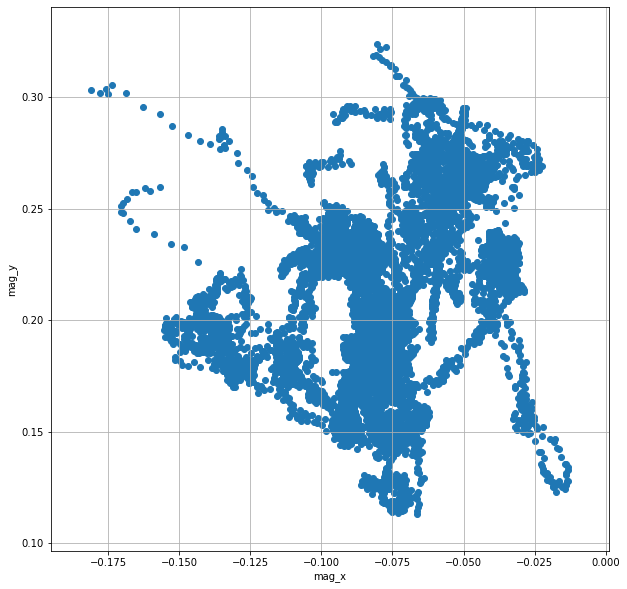

In [474]:
plt.figure(figsize=(10,10))
plt.scatter(np.array(mag_x),np.array(mag_y))
plt.grid(True)
plt.xlabel("mag_x")
plt.ylabel("mag_y")
mag_x

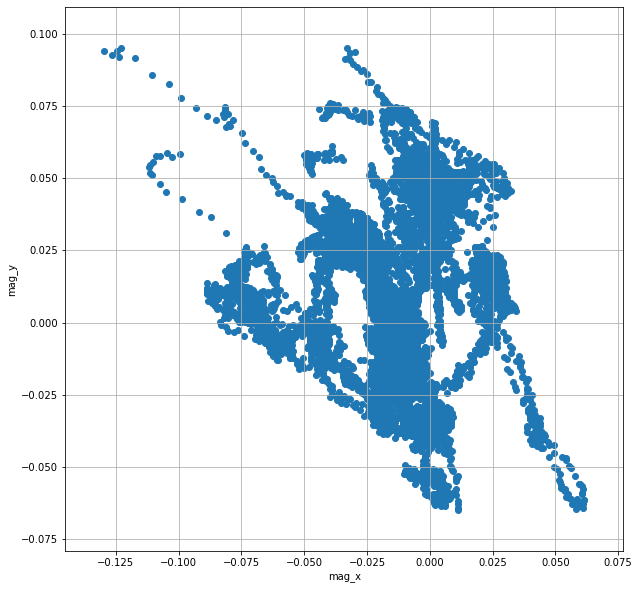

In [475]:
mc=[]
cc=[[0.99 ,-0.1443,0],[-0.1443, 0.75, 0],[0, 0, 1]]
cx=[[mag_x+0.065],[mag_y-0.2],[mag_z-0]]
cx=np.array(cx)
np.shape(cx)
# for data in cx:
#     print (data[data])
for i in range(23283):
    mc.append(np.dot(cc,(cx[:,:,i])))
mc=np.array(mc)
for i in range(23283):
    mx=mc[:,0,0]
    my=mc[:,1,0]
    mz=mc[:,2,0]
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel("mag_x")
plt.ylabel("mag_y")
plt.scatter(mx,my)


array([-0.45334822, -0.35153748, -0.39211432, ...,  2.88629704,
        2.85881245,  2.78302438])

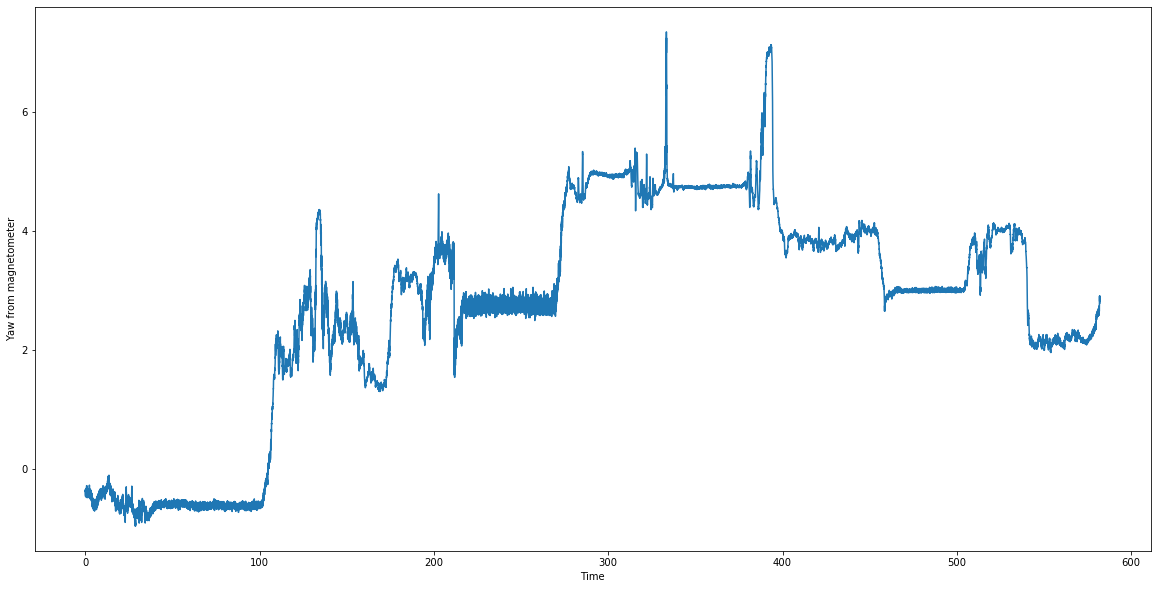

In [476]:
#Yaw from Magnetometer, to low pass 
yaw_mag=np.arctan2(-my,mx) #radian
yaw_mag=np.unwrap(yaw_mag)
plt.figure(figsize=(20,10))
plt.xlabel("Time")
plt.ylabel("Yaw from magnetometer")
plt.plot(timeimu,yaw_mag)

yaw_mag

2.7167744093972406

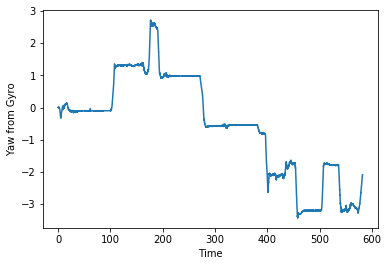

In [477]:
#Yaw from gyro
yaw_rate=np.array(d['field.IMU.angular_velocity.z'])
yaw_gyro=cumtrapz(yaw_rate,timeimu)+yaw_rate[1:]
yaw_gyro=np.insert(yaw_gyro,0,0+yaw_rate[0])
plt.xlabel("Time")
plt.ylabel("Yaw from Gyro")

plt.plot(timeimu,yaw_gyro)
max(yaw_gyro)

4.259496418564904

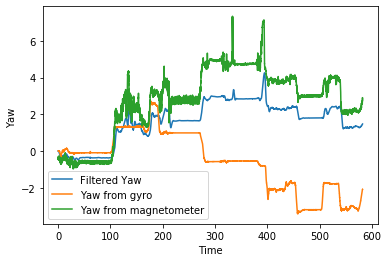

In [485]:
#Filter
# Define filter parameters
cut_off_freq=0.01 # Cutoff frequency for low-pass filter
filter_order = 4  # Filter order
# Initialize low-pass (for magnetometer) and high-pass (for gyro) filters
gyro_b, gyro_a = butter(filter_order, cut_off_freq, btype='high')
mag_b, mag_a = butter(filter_order, cut_off_freq, btype='low')
# yaw_gyro=np.unwrap(yaw_gyro)
# yaw_mag=np.unwrap(yaw_mag)
filtered_gyro = np.zeros(len(yaw_gyro))
filtered_mag = np.zeros(len(yaw_mag))
yaw_estimate = np.zeros(len(yaw_gyro))

# Apply filters to gyro and magnetometer data
filtered_gyro = lfilter(gyro_b, gyro_a, yaw_gyro)
filtered_mag = lfilter(mag_b, mag_a, yaw_mag)

# Complementary filter
alpha = 0.6  # Weight for magnetometer data (low-pass filter)
gyro_weight = 1.0 - alpha  # Weight for gyro data (high-pass filter)

for i in range(len(yaw_gyro)):    
    
    # Apply filters
    filtered_gyro_yaw = filtered_gyro[i]
    filtered_mag_yaw = filtered_mag[i]
    
    # Combine data using complementary filter
    yaw_estimate[i] = alpha * filtered_mag_yaw + gyro_weight*filtered_gyro_yaw
    # Ensure the yaw estimate stays within the range of -π to π
    #yaw_estimate = (yaw_estimate + np.pi) % (2 * np.pi) - np.pi
plt.xlabel("Time")
plt.ylabel("Yaw ")
plt.plot(timeimu,yaw_estimate)
plt.plot(timeimu,yaw_gyro)
plt.plot(timeimu,yaw_mag)
plt.legend(['Filtered Yaw','Yaw from gyro','Yaw from magnetometer'])
max(yaw_estimate)


10.99773455219196

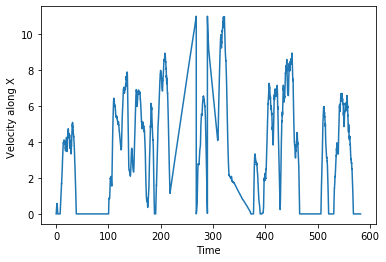

In [479]:
 #velocity from linear acceleration
lin_acc_x=np.array(d['field.IMU.linear_acceleration.x']+0.55) #0.55355
lin_acc_y=np.array(d['field.IMU.linear_acceleration.y']) 
lin_acc_z=np.array(d['field.IMU.linear_acceleration.z']) 
v_x=cumtrapz(lin_acc_x,timeimu)
v_x=np.insert(v_x,0,0)
for i in range(len(v_x)):
    v_x[i]=max(0.0,v_x[i])
    if v_x[i]>11:
        v_x[i]=v_x[i]-11
#plt.plot(timeimu,lin_acc_x)
plt.plot(timeimu,v_x)
plt.xlabel("Time")
plt.ylabel("Velocity along X ")
max(v_x)


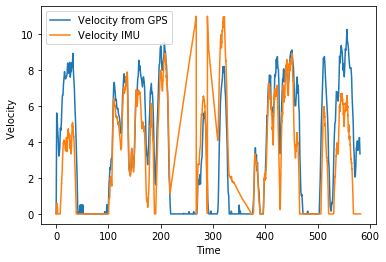

In [486]:
#velocity from GPS
timegps=np.array((ds['field.header.stamp']-1698264349220810651)/1000000000)
easting=np.array(ds['field.utm_easting'])
northing=np.array(ds['field.utm_northing'])
velocity_x=diff(easting)/diff(timegps)
velocity_x = np.insert(velocity_x, 0, 0)
velocity_y=diff(northing)/diff(timegps)
velocity_y= np.insert(velocity_y, 0, 0)
velocity=(velocity_y**2+velocity_x**2)**0.5
plt.plot(timegps,velocity)
plt.plot(timeimu,v_x)

plt.xlabel("Time")
plt.ylabel("Velocity  ")
plt.legend(['Velocity from GPS','Velocity IMU'])

# fig=px.line(x=timegps,y=velocity)
# fig.show()


Text(0, 0.5, 'Displacement ')

<Figure size 432x288 with 0 Axes>

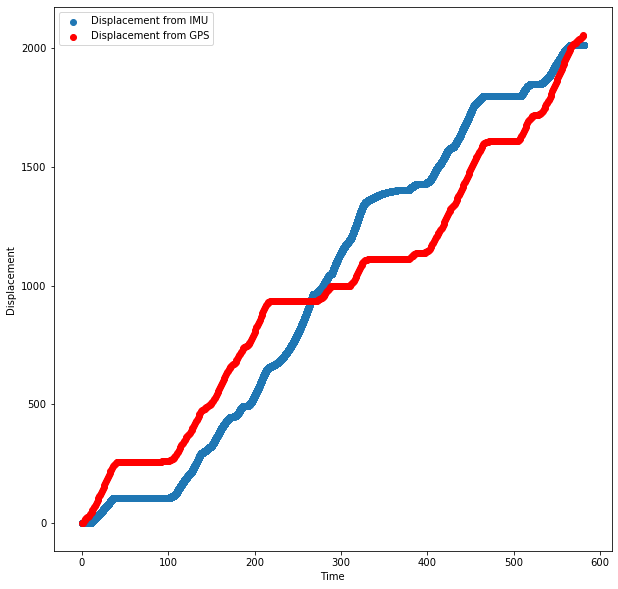

In [481]:
#Displacement
plt.figure()
plt.figure(figsize=(10,10))

displacement_imu=cumtrapz(v_x,timeimu)
displacement_imu=np.insert(displacement_imu,0,0)
plt.scatter(timeimu,displacement_imu)
displacement_gps=cumtrapz(velocity,timegps)
displacement_gps=np.insert(displacement_gps,0,0)
plt.scatter(timegps,displacement_gps,color='red')
#plt.scatter(timegps,signs_gps)
plt.legend(['Displacement from IMU','Displacement from GPS'])
plt.xlabel("Time")
plt.ylabel("Displacement ")

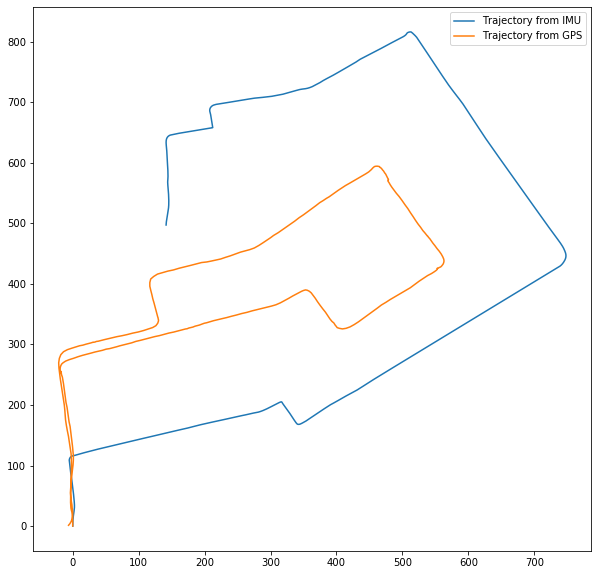

In [482]:
#Trajectroy
#yaw_degree=np.rad2deg(np.array(yaw_gyro))
Ve=v_x*np.sin(yaw_gyro)
Vn=v_x*np.cos(yaw_gyro)
Xe=cumtrapz(Ve,timeimu)
Xn=cumtrapz(Vn,timeimu)
plt.figure(figsize=(10,10))
plt.plot(Xe,Xn)
plt.plot(np.cos(-0.2) * (easting-327857.75) - np.sin(-0.2) * (northing-4689338.5), #SCALING AND ROTATION
        np.sin(-0.2) * (easting-327857.75) + np.cos(-0.2) * (northing-4689338.5))
plt.legend(['Trajectory from IMU','Trajectory from GPS'])

#plt.plot(easting,northing)

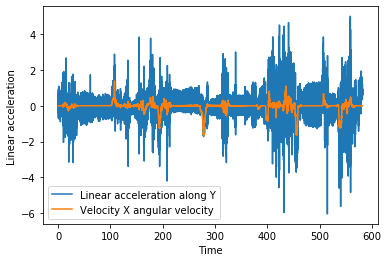

In [483]:
#dead reckoning
acc_obs=v_x*yaw_rate
plt.figure()
#plt.subplot(2,1,1)
plt.plot(timeimu,lin_acc_y)
#plt.subplot(2,1,2)
plt.plot(timeimu,acc_obs)
plt.xlabel("Time")
plt.ylabel("Linear acceleration ")
plt.legend(['Linear acceleration along Y','Velocity X angular velocity'])
